In [118]:
import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from catboost import CatBoostClassifier
from scipy.sparse import hstack
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from tqdm import tqdm_notebook, tqdm
from scipy import stats
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GroupKFold, train_test_split
import re
from sklearn.preprocessing import LabelEncoder
#from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import lightgbm as lgb
from category_encoders import *
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = [5, 5]
pd.set_option('display.max_columns', None)

import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing, model_selection

In [119]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission_iA3afxn.csv')

In [120]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [121]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [122]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [123]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

<AxesSubplot:>

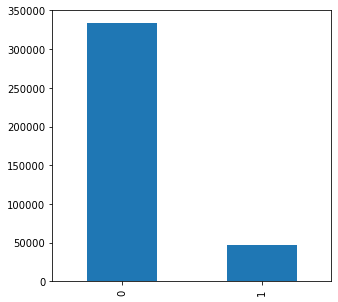

In [124]:
# Checking the Target Variable
train['Response'].value_counts().plot(kind='bar')

In [125]:
# getting the counts of each customer
for cols in train.columns:
    print('------------------------------------')
    print(train[cols].value_counts())

------------------------------------
2049      1
99738     1
19875     1
17826     1
23969     1
         ..
303809    1
305856    1
86655     1
88702     1
2047      1
Name: id, Length: 381109, dtype: int64
------------------------------------
Male      206089
Female    175020
Name: Gender, dtype: int64
------------------------------------
24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: Age, Length: 66, dtype: int64
------------------------------------
1    380297
0       812
Name: Driving_License, dtype: int64
------------------------------------
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       

In [126]:
print(train.shape)
print(test.shape)

(381109, 12)
(127037, 11)


In [127]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [128]:
# map them
train['Vehicle_Age'] = train['Vehicle_Age'].replace({'1-2 Year':1, '< 1 Year':0, '> 2 Years':2})
# map them
test['Vehicle_Age'] = test['Vehicle_Age'].replace({'1-2 Year':1, '< 1 Year':0, '> 2 Years':2})

In [129]:
train['Vehicle_Damage'] = train['Vehicle_Damage'].map({'Yes':1, 'No':0})
test['Vehicle_Damage'] = test['Vehicle_Damage'].map({'Yes':1, 'No':0})

In [130]:
train['Gender'] = train['Gender'].astype('category').cat.codes
test['Gender'] = test['Gender'].astype('category').cat.codes

In [131]:
#train = pd.get_dummies(train, columns=['Gender', 'Vehicle_Damage'])

In [132]:
#test = pd.get_dummies(test, columns=['Gender', 'Vehicle_Damage'])

In [133]:
df = train.append(test, ignore_index=True, sort=False)

In [134]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [135]:
#df = df[['Age', 'Annual_Premium', 'Vintage','Policy_Sales_Channel','id', 'Gender','Region_Code','Response',
   #     'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Driving_License']]

In [136]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0


### Feature Engineering

In [137]:
df['Region_Count'] = df['Region_Code'].map(df['Region_Code'].value_counts())
#df['Policy_Sales_Channel_Count'] = df['Policy_Sales_Channel'].map(df['Policy_Sales_Channel'].value_counts())

In [138]:
df['policy_region'] = df['Policy_Sales_Channel'].astype(str) + '_' + df['Region_Code'].astype(str)

In [139]:
#df['policy_region'] = df['policy_region'].astype('category').cat.codes

In [140]:
df['policy_region'] = df['policy_region'].map(df['policy_region'].value_counts())

In [141]:
def aggregate_functions(df):        
    
    agg_func = {
        'Annual_Premium' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Vintage' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Region_Count' : ['min', 'max', 'std', 'mean', 'median', 'sum']}
    
    agg_df = df.groupby(['Region_Code']).agg(agg_func)
    agg_df.columns = ['_by_region'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    agg_df = pd.merge(df, agg_df, on='Region_Code', how='left')
    
    return agg_df

In [142]:
df = aggregate_functions(df)

In [143]:
def aggregate_functions(df):        
    
    agg_func = {
        'Annual_Premium' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Vintage' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Region_Count' : ['min', 'max', 'std', 'mean', 'median', 'sum']
        }
    
    agg_df = df.groupby(['Policy_Sales_Channel']).agg(agg_func)
    agg_df.columns = ['_by_policy'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    agg_df = pd.merge(df, agg_df, on='Policy_Sales_Channel', how='left')
    
    return agg_df

In [144]:
df = aggregate_functions(df)

In [145]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Count,policy_region,Annual_Premium_by_regionmin,Annual_Premium_by_regionmax,Annual_Premium_by_regionnunique,Annual_Premium_by_regionsize,Annual_Premium_by_regionstd,Annual_Premium_by_regionmean,Annual_Premium_by_regionmedian,Annual_Premium_by_regionsum,Vintage_by_regionmin,Vintage_by_regionmax,Vintage_by_regionnunique,Vintage_by_regionsize,Vintage_by_regionstd,Vintage_by_regionmean,Vintage_by_regionmedian,Vintage_by_regionsum,Region_Count_by_regionmin,Region_Count_by_regionmax,Region_Count_by_regionstd,Region_Count_by_regionmean,Region_Count_by_regionmedian,Region_Count_by_regionsum,Annual_Premium_by_policymin,Annual_Premium_by_policymax,Annual_Premium_by_policynunique,Annual_Premium_by_policysize,Annual_Premium_by_policystd,Annual_Premium_by_policymean,Annual_Premium_by_policymedian,Annual_Premium_by_policysum,Vintage_by_policymin,Vintage_by_policymax,Vintage_by_policynunique,Vintage_by_policysize,Vintage_by_policystd,Vintage_by_policymean,Vintage_by_policymedian,Vintage_by_policysum,Region_Count_by_policymin,Region_Count_by_policymax,Region_Count_by_policystd,Region_Count_by_policymean,Region_Count_by_policymedian,Region_Count_by_policysum
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,141937,50117,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,12349,2240,2630.0,424578.0,7473,12349,14589.746562,24465.445218,26055.0,3.021238e+08,10,299,290,12349,82.796075,154.864442,154.0,1912421,12349,12349,0.0,12349,12349,152497801,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,141937,50117,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,12328,6735,2630.0,193637.0,7705,12328,14000.397877,27655.183160,29099.5,3.409331e+08,10,299,290,12328,83.740509,154.520360,154.0,1904927,12328,12328,0.0,12328,12328,151979584,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,24400,11503,2630.0,339396.0,13801,24400,15174.548982,30948.979918,31623.5,7.551551e+08,10,299,290,24400,83.736493,154.851189,155.0,3778369,24400,24400,0.0,24400,24400,595360000,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520


In [146]:
train = df[df['Response'].isnull()!=True] # every column features including the response features that is not null
test = df[df['Response'].isnull()==True] #  every column features including the response features that is null
test.drop('Response', axis=1, inplace=True)  # dropping response features

C:\Users\ITD\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [147]:
train['Vintage'].describe()

count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [148]:
train['Vintage'].corr(train['Annual_Premium'])

-0.0006084171513098564

In [149]:
test_id = test['id']

In [150]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [151]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Count,policy_region,Annual_Premium_by_regionmin,Annual_Premium_by_regionmax,Annual_Premium_by_regionnunique,Annual_Premium_by_regionsize,Annual_Premium_by_regionstd,Annual_Premium_by_regionmean,Annual_Premium_by_regionmedian,Annual_Premium_by_regionsum,Vintage_by_regionmin,Vintage_by_regionmax,Vintage_by_regionnunique,Vintage_by_regionsize,Vintage_by_regionstd,Vintage_by_regionmean,Vintage_by_regionmedian,Vintage_by_regionsum,Region_Count_by_regionmin,Region_Count_by_regionmax,Region_Count_by_regionstd,Region_Count_by_regionmean,Region_Count_by_regionmedian,Region_Count_by_regionsum,Annual_Premium_by_policymin,Annual_Premium_by_policymax,Annual_Premium_by_policynunique,Annual_Premium_by_policysize,Annual_Premium_by_policystd,Annual_Premium_by_policymean,Annual_Premium_by_policymedian,Annual_Premium_by_policysum,Vintage_by_policymin,Vintage_by_policymax,Vintage_by_policynunique,Vintage_by_policysize,Vintage_by_policystd,Vintage_by_policymean,Vintage_by_policymedian,Vintage_by_policysum,Region_Count_by_policymin,Region_Count_by_policymax,Region_Count_by_policystd,Region_Count_by_policymean,Region_Count_by_policymedian,Region_Count_by_policysum
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,141937,50117,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,12349,2240,2630.0,424578.0,7473,12349,14589.746562,24465.445218,26055.0,3.021238e+08,10,299,290,12349,82.796075,154.864442,154.0,1912421,12349,12349,0.0,12349,12349,152497801,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,141937,50117,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,12328,6735,2630.0,193637.0,7705,12328,14000.397877,27655.183160,29099.5,3.409331e+08,10,299,290,12328,83.740509,154.520360,154.0,1904927,12328,12328,0.0,12328,12328,151979584,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,24400,11503,2630.0,339396.0,13801,24400,15174.548982,30948.979918,31623.5,7.551551e+08,10,299,290,24400,83.736493,154.851189,155.0,3778369,24400,24400,0.0,24400,24400,595360000,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520


In [152]:
X = train.drop("Response", axis=1)
y = train["Response"]

In [153]:
 # LGBMClassifier 
params = {}
params["objective"] = "binary"
params['metric'] = 'auc'
params["max_depth"] = -1
params["num_leaves"] = 64
params["min_data_in_leaf"] = 20

#params["min_sum_hessian_in_leaf"] = 5
params["learning_rate"] = 0.03
params["bagging_fraction"] = 0.9
params["feature_fraction"] = 0.35
params["feature_fraction_seed"] = 20
params["bagging_freq"] = 10
params["bagging_seed"] = 30
params["'min_child_weight'"] = 0.09
params["lambda_l1"] = 0.01
params["verbosity"] = -1

In [154]:
# Light GBMClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
errcb=[]
y_pred_totcb=[]
fold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMClassifier(**params,n_estimators=3000,reg_alpha=0.3434, reg_lambda=0.732745, colsample_bytree=0.29034,subsample=70,
                      subsample_freq=0.9)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=-1, early_stopping_rounds=100) #verbose=100)
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

[LightGBM] [Warning] min_child_weight is set=0.001, min_child_weight=0.09 will be ignored. Current value: min_child_weight=0.001
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.29034 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.3434 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=70 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0.9 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[280]	training's auc: 0.870924	valid_1's auc: 0.855255
err:  0.8552545758518151
[LightGBM] [Warning] min_child_weight is set=0.001, min_child_weight=0.09 will be ignored. Current value: 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[341]	training's auc: 0.871908	valid_1's auc: 0.859285
err:  0.8592852468849086


In [155]:
np.mean(errcb)

0.858994382536825

In [156]:
d = {"id": test_id, 'Response': np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
subs = test_predictions[["id", 'Response']].round(4)

In [157]:
#subs['Response'] = subs['Response'].rank()

In [158]:
subs.to_csv('lgb23.csv', index=False)

In [159]:
subs.head()

,id,Response
381109,381110,0.0021
381110,381111,0.3399
381111,381112,0.2922
381112,381113,0.0122
381113,381114,0.0018


In [160]:
subs['Response'].isnull().sum()

0

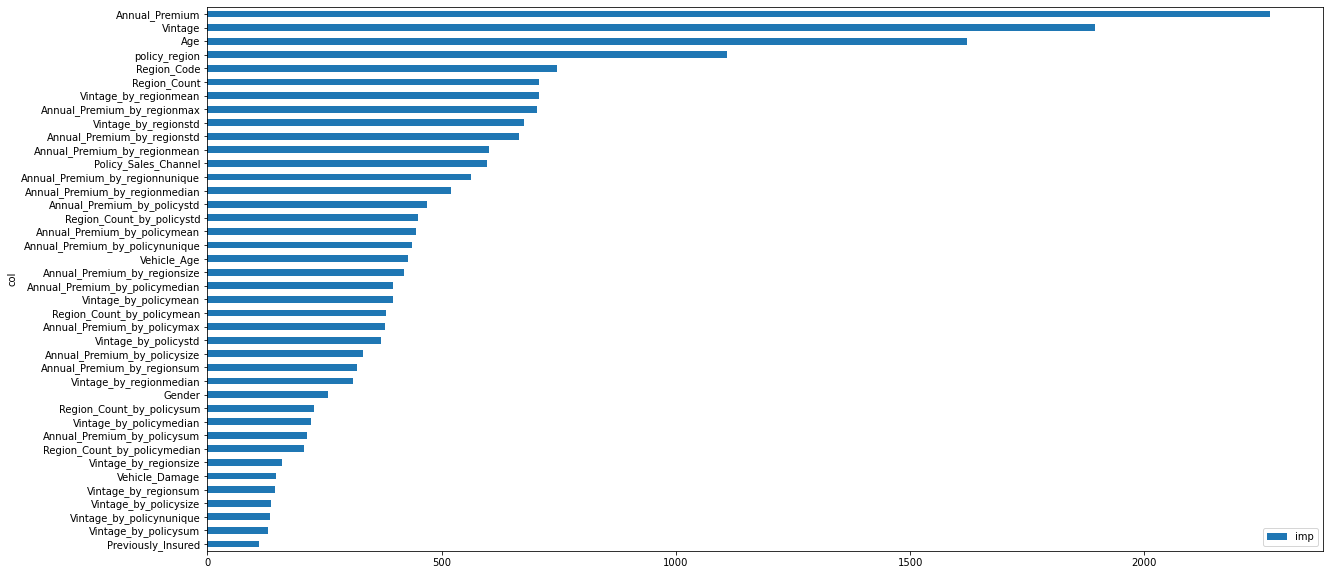

In [161]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-40:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [164]:
a = pd.read_csv('cat9.csv')
b = pd.read_csv('lgb23.csv')

In [165]:
#(0.46 * a['Response'] + 0.54 * b['Response']).round(3)

In [166]:
a['Response'] = (0.46 * a['Response'] + 0.54 * b['Response']).round(3)

In [167]:
a.to_csv('stack14.csv', index=False)